In [1]:
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [2]:
%pylab inline
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time
from sklearn.cluster import KMeans
from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from scipy.misc import imread
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

Populating the interactive namespace from numpy and matplotlib


In [0]:
(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()

In [4]:
!pip3 install imgaug

    100% |████████████████████████████████| 634kB 5.1MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [0]:
from imgaug import augmenters as iaa
seq = iaa.Sequential([iaa.SaltAndPepper(0.2)])

train_x_aug = seq.augment_images(train_x)
val_x_aug = seq.augment_images(val_x)

In [0]:
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

train_x_aug = train_x_aug/255.
val_x_aug = val_x_aug/255.

train_x_aug = train_x_aug.reshape(-1, 28, 28, 1)
val_x_aug = val_x_aug.reshape(-1, 28, 28, 1)

In [0]:
import tensorflow as tf

In [0]:
with tf.device('/gpu:0'):
    # this is our input placeholder
    input_img = Input(shape=(28, 28, 1))

    # "encoded" is the encoded representation of the input
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    encoded = MaxPool2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPool2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPool2D((2, 2), padding='same')(encoded)

    # "decoded" is the lossy reconstruction of the input
    decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(64, (3, 3), activation='relu')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(1, (3, 3), padding='same')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

In [9]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

In [0]:
encoder = Model(input_img, encoded)

In [0]:
autoencoder.compile(optimizer='adam', loss='mse')

In [0]:
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [13]:
with tf.device('/gpu:0'):
   train_history = autoencoder.fit(train_x_aug, train_x, epochs=500, batch_size=2048, validation_data=(val_x_aug, val_x), callbacks=[estop])

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 12s 204us/step - loss: 0.0977 - val_loss: 0.0535
Epoch 2/500
60000/60000 [==============================] - 8s 130us/step - loss: 0.0447 - val_loss: 0.0373
Epoch 3/500
60000/60000 [==============================] - 8s 130us/step - loss: 0.0342 - val_loss: 0.0309
Epoch 4/500
60000/60000 [==============================] - 8s 130us/step - loss: 0.0287 - val_loss: 0.0266
Epoch 5/500
60000/60000 [==============================] - 8s 130us/step - loss: 0.0255 - val_loss: 0.0243
Epoch 6/500
60000/60000 [==============================] - 8s 130us/step - loss: 0.0238 - val_loss: 0.0230
Epoch 7/500
60000/60000 [==============================] - 8s 130us/step - loss: 0.0225 - val_loss: 0.0220
Epoch 8/500
60000/60000 [==============================] - 8s 130us/step - loss: 0.0217 - val_loss: 0.0213
Epoch 9/500
60000/60000 [==============================] - 8s 130us/step - loss: 0.0210 - val

In [0]:
pred = autoencoder.predict(val_x)

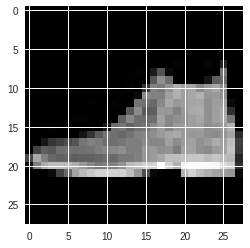

In [15]:
plt.imshow(val_x[0].reshape(28, 28), cmap='gray')

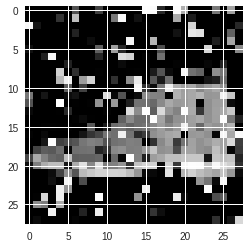

In [16]:
plt.imshow(val_x_aug[0].reshape(28, 28), cmap='gray')